In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
#import loompy
import matplotlib as mpl
import harmonypy as hm

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.settings.set_figure_params(dpi=80, color_map='viridis')
#sc.logging.print_versions()

In [2]:
input_file = '/lustre/scratch126/cellgen/team205/rl20/CTCL/object_revision/B_Plasma_CTCL_all_final_20240707_raw.h5ad'
adata = sc.read_h5ad(input_file)

In [3]:
adata

AnnData object with n_obs × n_vars = 20780 × 15790
    obs: 'Sanger_ID', 'tissue', 'site', 'Sex', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'study', 'donor', 'tech', 'cell_type', 'barcode', 'type'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'broad_ct_colors', 'cell_type_colors', 'donor_colors', 'groups1_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'study_colors', 'tech_colors', 'tissue_colors'
    obsm: 'X_scVI', 'X_scVI_MDE', '_scvi_extra_categorical_covs'
    layers: 'raw_counts'
    obsp: 'connectivities', 'distances'

In [5]:
adata = adata[adata.obs['cell_type']=='B_cell'].copy()

In [6]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


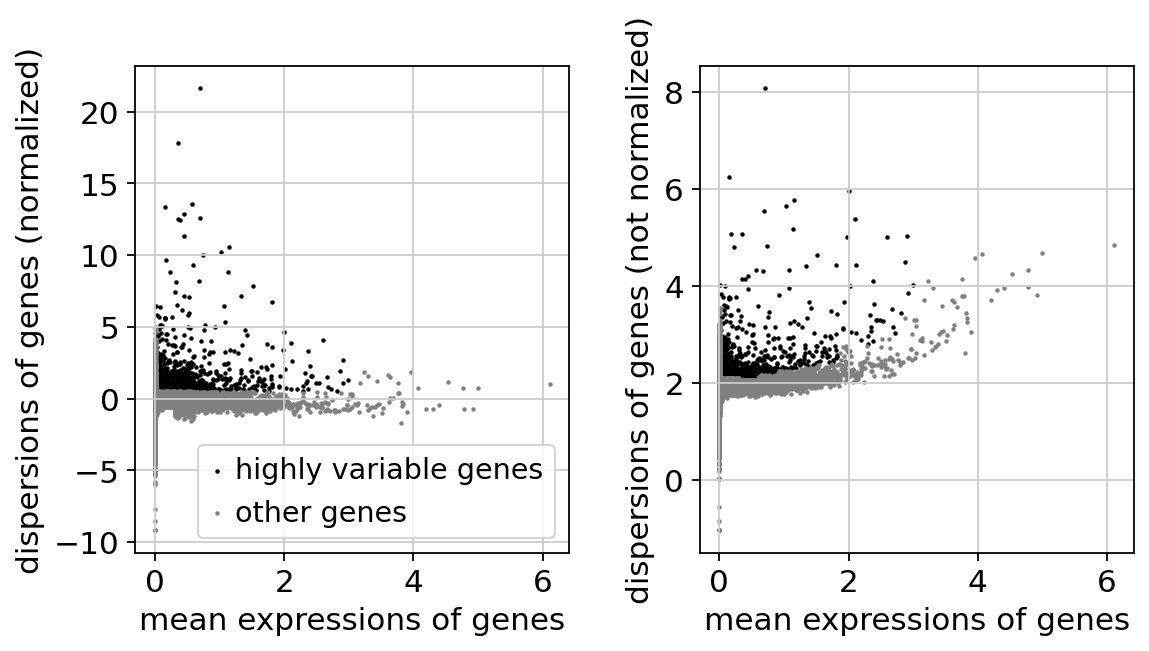

In [7]:
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [8]:
adata.var['highly_variable'].value_counts()

False    14333
True      1457
Name: highly_variable, dtype: int64

In [9]:
### remove IGgenes from HVG
import re
for i in adata.var.index:
    if re.search('^IG[HKL][VDJC]', i):
        adata.var.at[i, 'highly_variable'] = False

In [10]:
adata.var['highly_variable'].value_counts()

False    14336
True      1454
Name: highly_variable, dtype: int64

In [11]:
adata_filtered = adata[:, adata.var['highly_variable']]

In [12]:
sc.pp.scale(adata_filtered, max_value=10)

/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [ ]:
sc.tl.pca(adata_filtered, n_comps=50)
sc.pl.pca(adata_filtered, color = ['donor'])

In [14]:
adata_filtered_harmony = adata_filtered.copy()

In [15]:
#Set harmony variables
pca = np.array(adata_filtered_harmony.obsm["X_pca"])
batch = adata_filtered_harmony.obs['donor']
meta_data = adata_filtered_harmony.obs

#Run Harmony
ho = hm.run_harmony(pca, meta_data, ['donor'], theta = 3, random_state = 1234)
res = (pd.DataFrame(ho.Z_corr)).T
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

#Insert coordinates back into object
adata_filtered_harmony.obsm["X_pca_back"]= adata_filtered_harmony.obsm["X_pca"][:]
adata_filtered_harmony.obsm["X_pca"] = np.array(res)

2024-07-18 15:29:13,816 - harmonypy - INFO - Iteration 1 of 10
2024-07-18 15:29:25,802 - harmonypy - INFO - Iteration 2 of 10
2024-07-18 15:29:41,085 - harmonypy - INFO - Converged after 2 iterations


In [16]:
sc.pp.neighbors(adata_filtered_harmony, n_neighbors=15, n_pcs=50, random_state = 1234)
sc.tl.umap(adata_filtered_harmony)

computing neighbors
    using 'X_pca' with n_pcs = 50


/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/numba/core/typed_passes.py:327: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-c

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:10)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


In [ ]:
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.pl.umap(adata_filtered_harmony, color=['donor'])

In [19]:
sc.tl.leiden(adata_filtered_harmony, resolution=0.8, key_added='leiden_0.8')

running Leiden clustering
    finished: found 10 clusters and added
    'leiden_0.8', the cluster labels (adata.obs, categorical) (0:00:02)


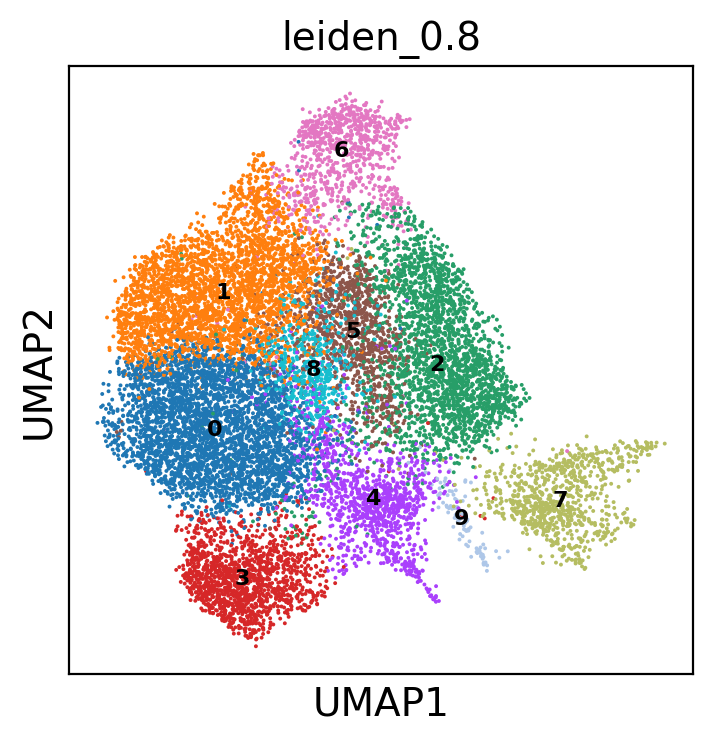

In [20]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata_filtered_harmony, color=['leiden_0.8'], legend_loc='on data',legend_fontsize=8)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:17)


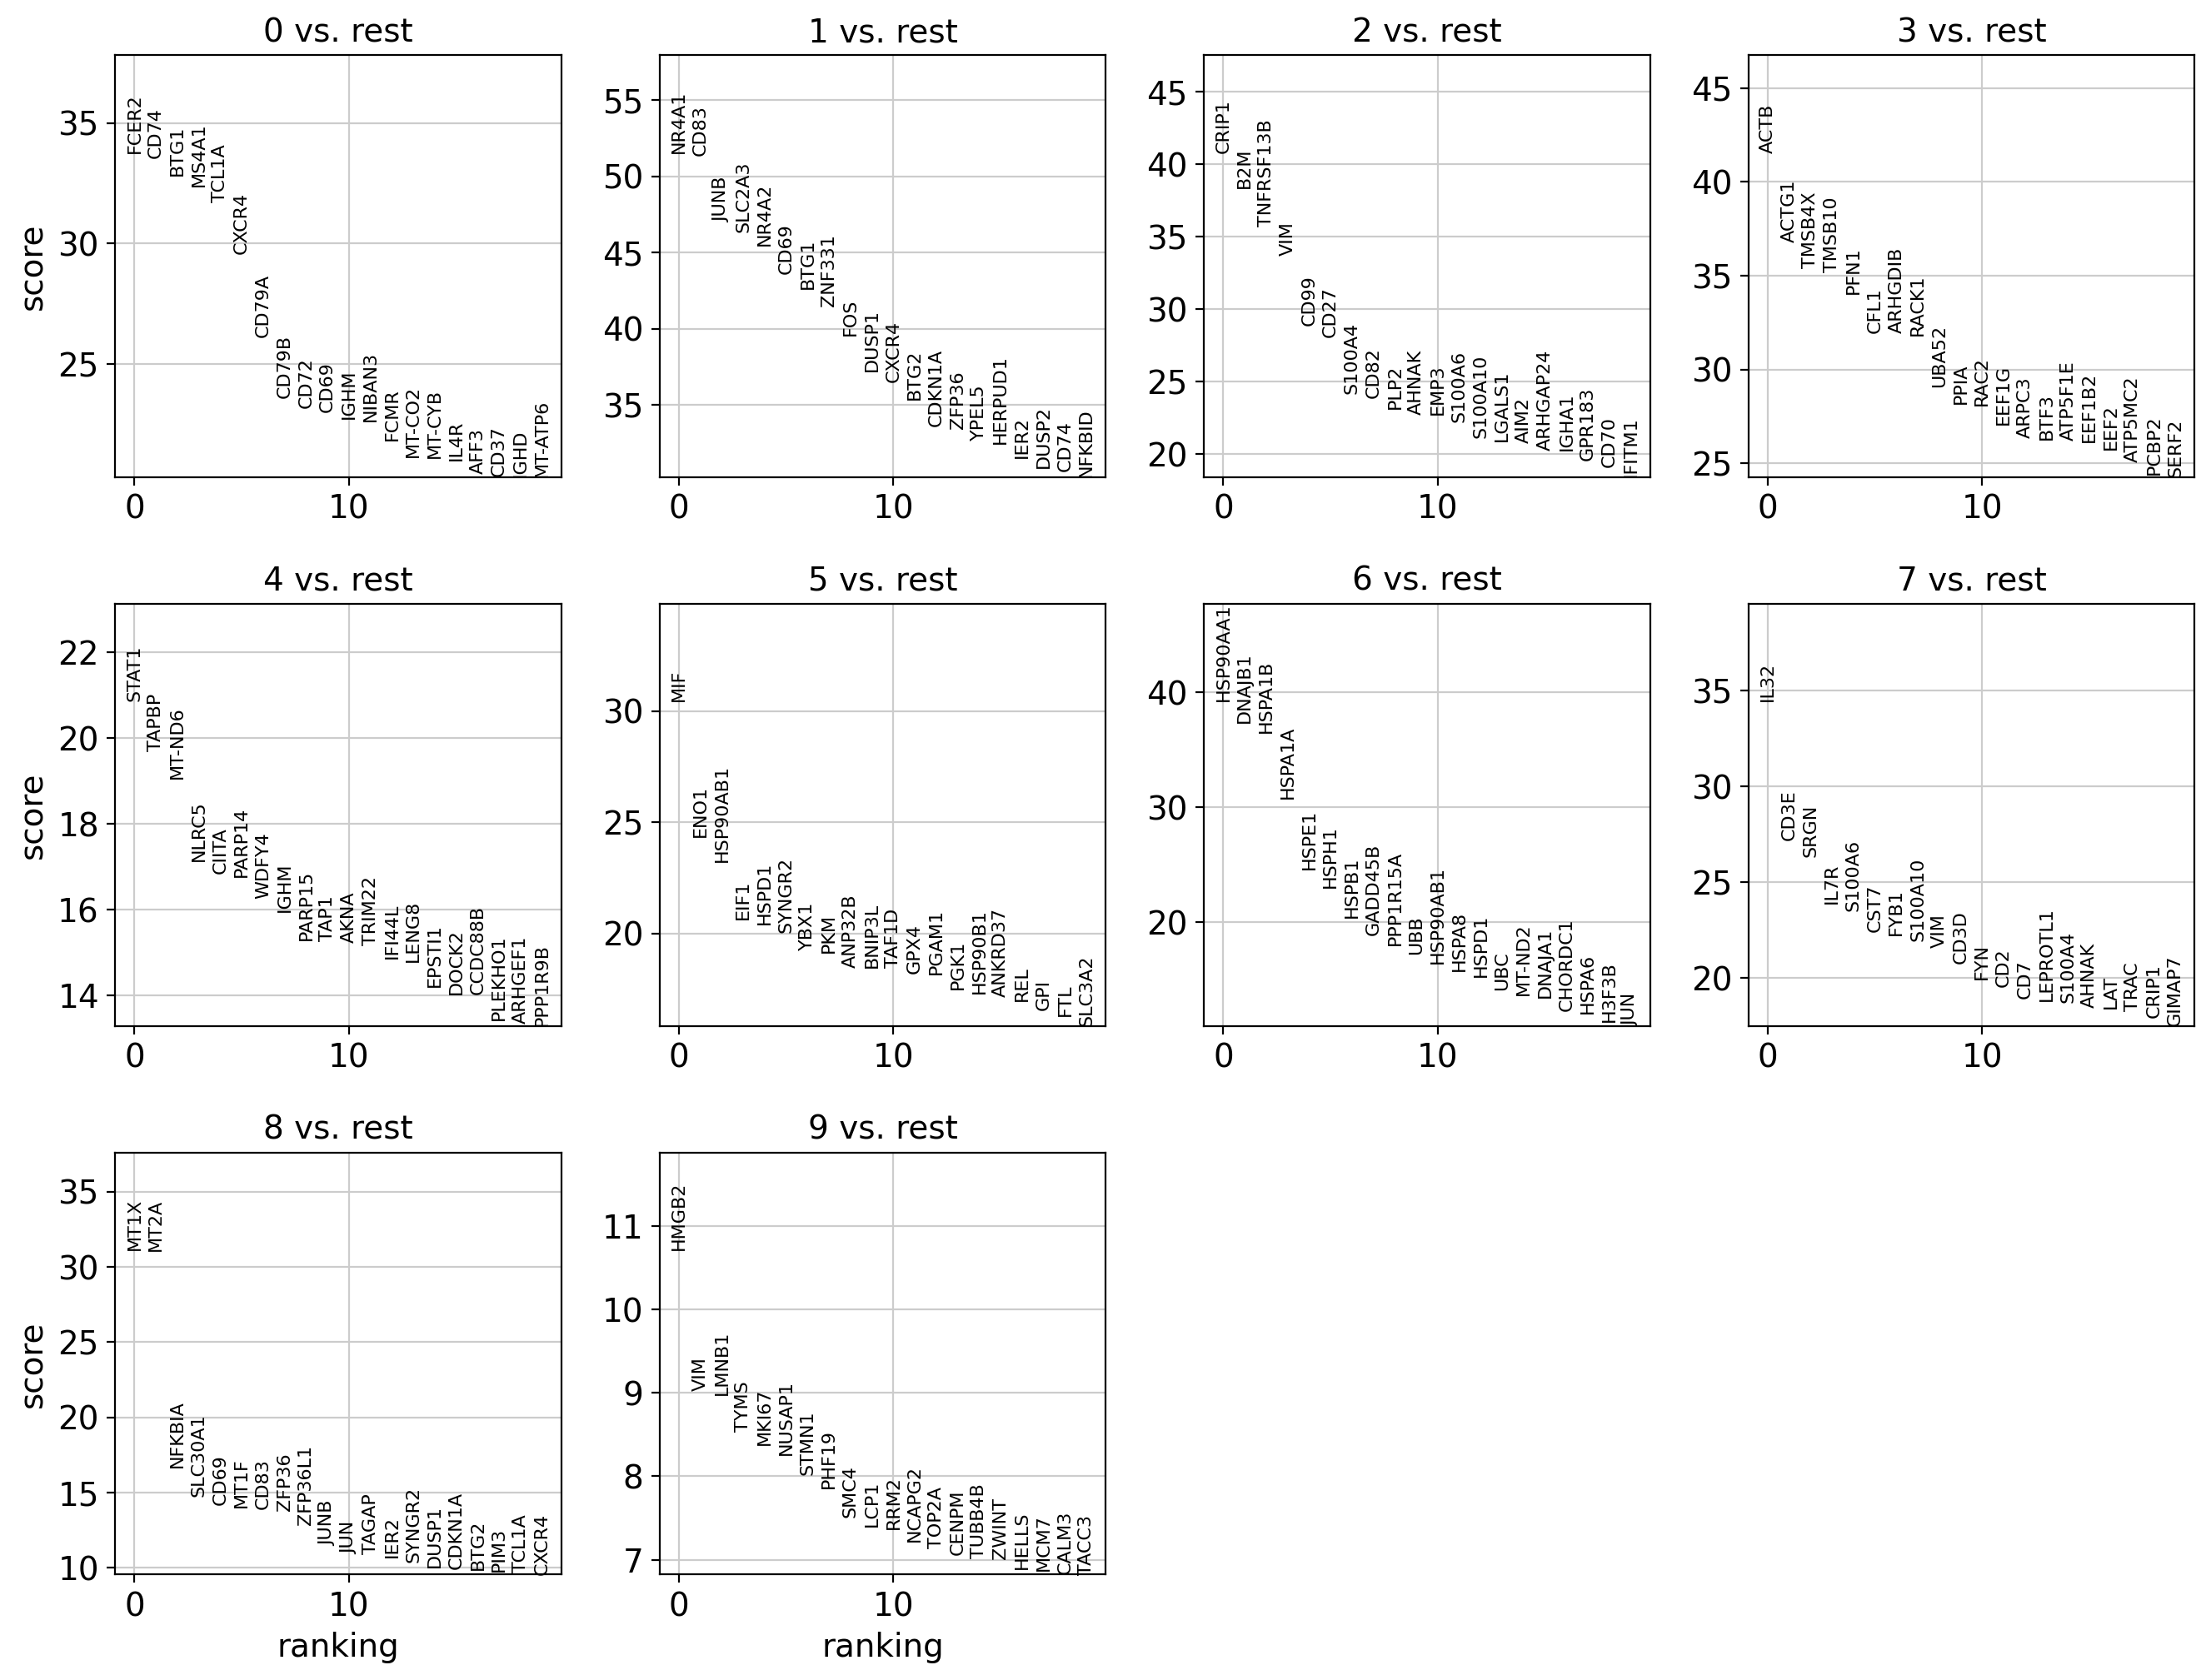

,0_n,0_p,0_l,1_n,1_p,1_l,2_n,2_p,2_l,3_n,...,6_l,7_n,7_p,7_l,8_n,8_p,8_l,9_n,9_p,9_l
0,FCER2,1.047383e-245,1.653522,NR4A1,0.000000e+00,3.018375,CRIP1,0.000000e+00,2.855222,ACTB,...,3.275219,IL32,9.021861e-256,6.081697,MT1X,1.811512e-208,6.896517,HMGB2,7.110698e-23,3.586066
1,CD74,1.149300e-242,0.632295,CD83,0.000000e+00,2.359456,B2M,0.000000e+00,0.749987,ACTG1,...,4.364585,CD3E,6.785248e-159,6.345699,MT2A,2.805788e-208,6.479105,VIM,5.936126e-16,2.227408
2,BTG1,2.033337e-232,1.140868,JUNB,0.000000e+00,2.412804,TNFRSF13B,6.242428e-276,3.186729,TMSB4X,...,5.043166,SRGN,3.179527e-149,2.683481,NFKBIA,1.596065e-58,1.886101,LMNB1,6.943816e-16,4.283434
3,MS4A1,4.946022e-226,0.951634,SLC2A3,0.000000e+00,2.099873,VIM,5.872332e-246,1.889758,TMSB10,...,5.348871,IL7R,7.155195e-123,6.373831,SLC30A1,1.756043e-45,4.293487,TYMS,2.195791e-14,7.225700
4,TCL1A,5.205175e-217,1.681095,NR4A2,0.000000e+00,2.446216,CD99,2.447032e-180,1.690790,PFN1,...,2.261397,S100A6,1.271133e-118,2.828259,CD69,2.480586e-42,1.978190,MKI67,7.735098e-14,7.605707
5,CXCR4,1.286956e-188,1.298644,CD69,0.000000e+00,2.617506,CD27,7.296388e-170,2.947254,CFL1,...,3.587461,CST7,5.338366e-108,6.767564,MT1F,2.224946e-41,4.969000,NUSAP1,1.441569e-13,6.121129
6,CD79A,7.465156e-147,0.892984,BTG1,0.000000e+00,1.531834,S100A4,6.514646e-126,2.274894,ARHGDIB,...,3.194297,FYB1,2.369844e-106,5.004113,CD83,1.459664e-40,1.570429,STMN1,7.958793e-13,3.767110
7,CD79B,1.216735e-119,0.977904,ZNF331,0.000000e+00,2.566700,CD82,3.454886e-123,1.364208,RACK1,...,2.280540,S100A10,2.170551e-103,2.675853,ZFP36,6.495355e-40,1.548063,PHF19,2.843836e-12,4.504598
8,CD72,1.010172e-115,1.144994,FOS,0.000000e+00,2.318570,PLP2,1.334263e-115,1.648405,UBA52,...,1.546571,VIM,2.581017e-100,1.858739,ZFP36L1,1.638378e-34,1.149870,SMC4,3.386231e-11,3.573840
9,CD69,6.456618e-114,1.450866,DUSP1,3.148825e-300,2.070436,AHNAK,1.477546e-111,2.319615,PPIA,...,1.251199,CD3D,1.582550e-92,5.522110,JUNB,2.799148e-27,1.464228,LCP1,7.121074e-11,1.480448


In [21]:
sc.tl.rank_genes_groups(adata_filtered_harmony, 'leiden_0.8', method = 'wilcoxon', n_genes = 200, use_raw = True)
sc.pl.rank_genes_groups(adata_filtered_harmony, n_genes=20, sharey=False)
result = adata_filtered_harmony.uns['rank_genes_groups']
groups = result['names'].dtype.names
markers = pd.DataFrame(
{group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})
markers.head(10)

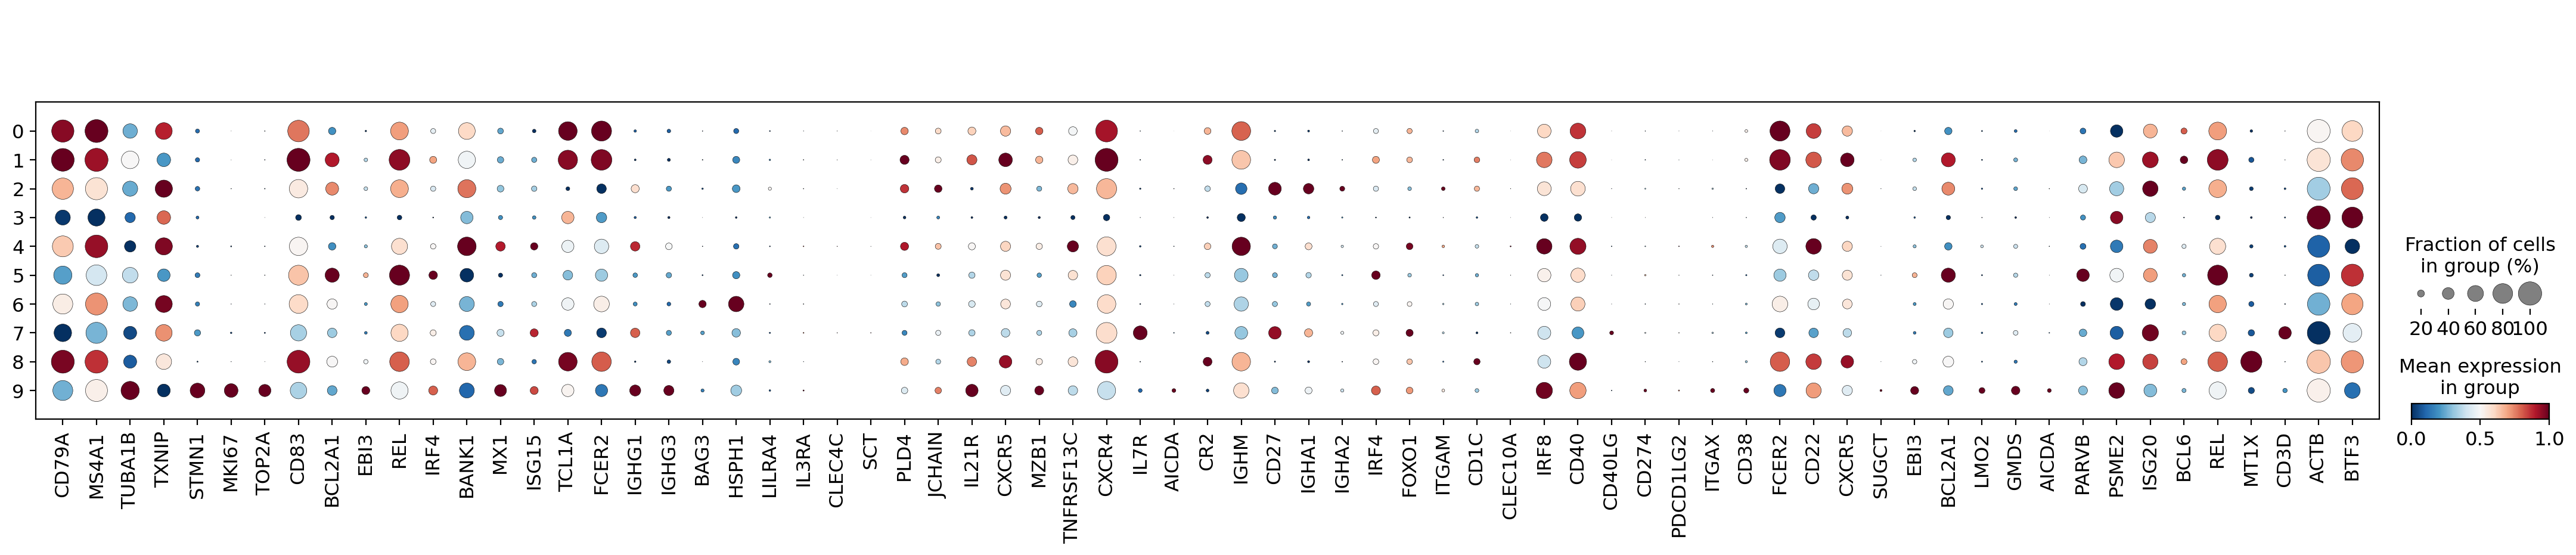

In [41]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
genes = ['CD79A','MS4A1','TUBA1B','TXNIP','STMN1','MKI67','TOP2A','CD83','BCL2A1','EBI3','REL','IRF4','BANK1',
         'MX1','ISG15','TCL1A','FCER2','IGHG1','IGHG3',
         'BAG3','HSPH1','LILRA4','IL3RA','CLEC4C','SCT','PLD4','JCHAIN',
         'IL21R','CXCR5','MZB1','TNFRSF13C','CXCR4','IL7R','AICDA','CR2','IGHM','CD27','IGHA1','IGHA2','IRF4','FOXO1',
         'ITGAM','CD1C','CLEC10A','IRF8','CD40','CD40LG','CD274','PDCD1LG2','ITGAX','CD38','FCER2','CD22','CXCR5',
         'SUGCT','EBI3','BCL2A1','LMO2','GMDS','AICDA','PARVB','PSME2','ISG20','BCL6','REL','MT1X','CD3D','ACTB','BTF3']

#genes = ['CD79A','MS4A1','FCER2','FCMR','SELL','BANK1','TCL1A','CR2','CD27','TNFRSF13B','IGHG1','IGHG3','CENPM','BAG3','HSPH1','CST3','EGR1']
#sc.tl.dendrogram(adata_filtered_harmony_sub, groupby='annotation')
dp = sc.pl.dotplot(adata_filtered_harmony, genes, groupby='leiden_0.8', use_raw=True, dendrogram=False, color_map='RdBu_r',standard_scale='var')

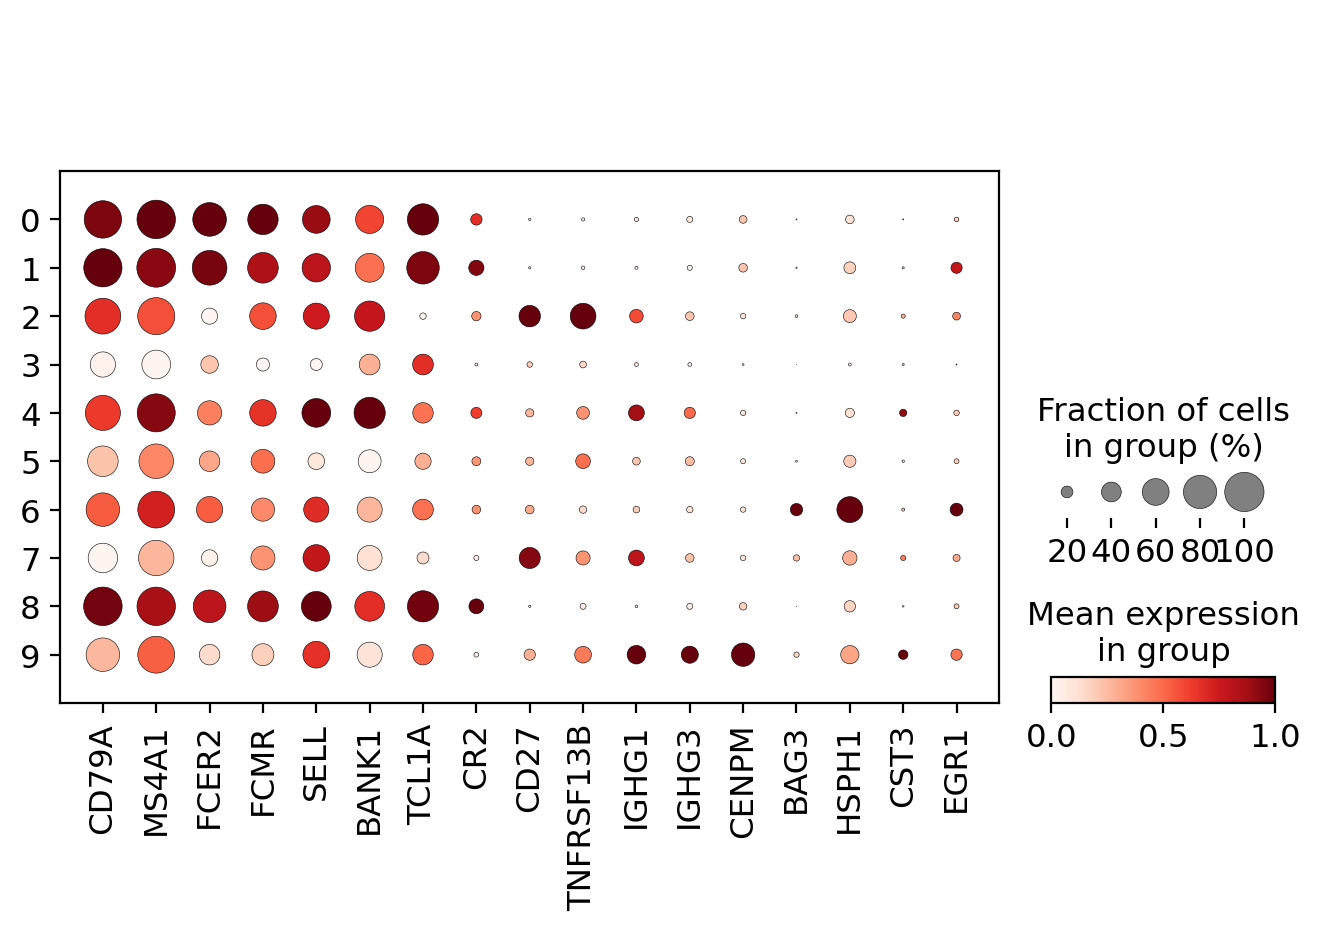

In [28]:
genes = ['CD79A','MS4A1','FCER2','FCMR','SELL','BANK1','TCL1A','CR2','CD27','TNFRSF13B','IGHG1','IGHG3','CENPM','BAG3','HSPH1','CST3','EGR1']
#sc.tl.dendrogram(adata_filtered_harmony_sub, groupby='annotation')
dp = sc.pl.dotplot(adata_filtered_harmony, genes, groupby='leiden_0.8', use_raw=True, dendrogram=False, color_map='Reds',standard_scale='var')

In [43]:
mye_dict = {'0':'Naive_B',
            '1':'Naive_B', 
            '2':'Memory_B',
            '3':'unknown',
            '4':'Naive_B',
            '5':'Memory_B',
            '6':'Stress_B',
            '7':'doublet',
            '8':'Naive_B',
            '9':'proliferative_B/GC-like',
           }

In [44]:
adata_filtered_harmony.obs['annotation'] = adata_filtered_harmony.obs['leiden_0.8'].map(mye_dict)

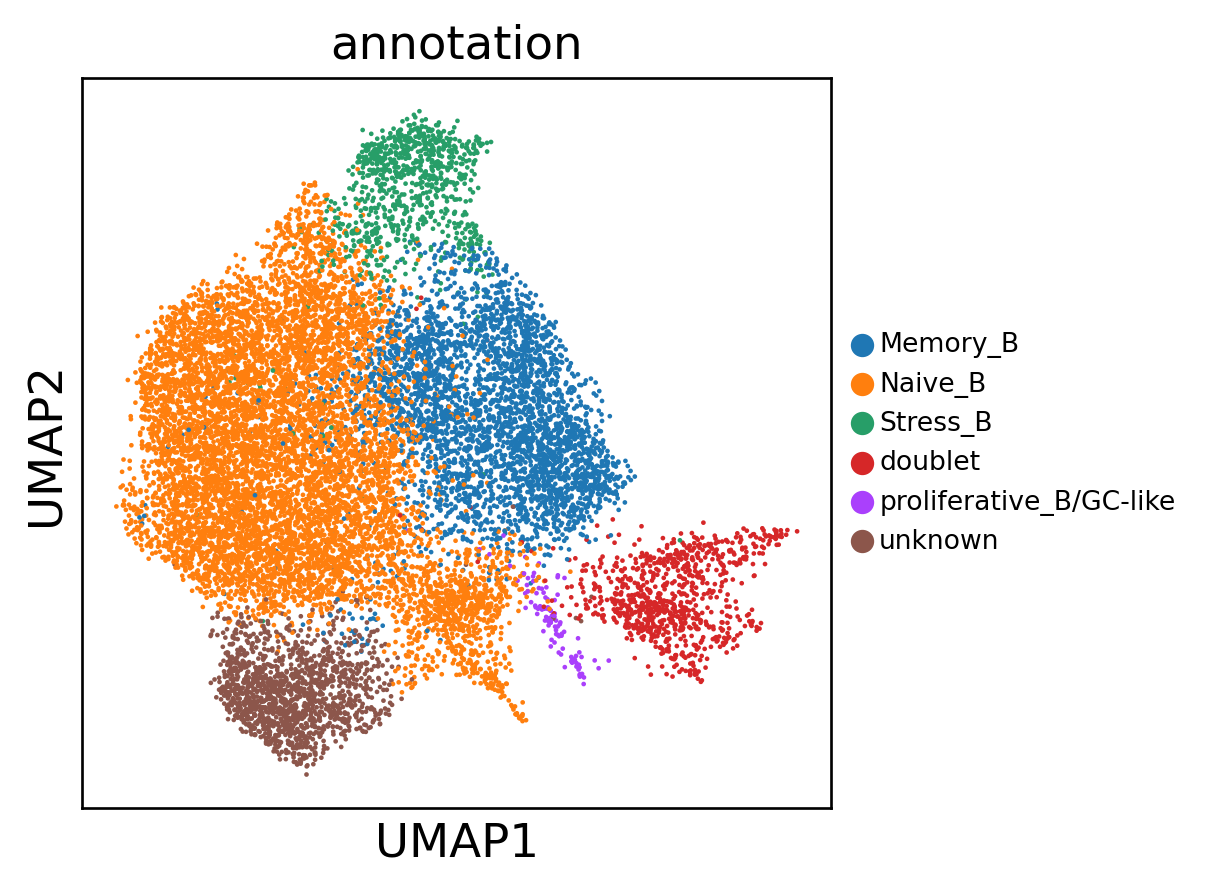

In [70]:
sc.settings.set_figure_params(dpi=120, facecolor='white')
sc.pl.umap(adata_filtered_harmony, color=['annotation'],legend_fontsize=8)

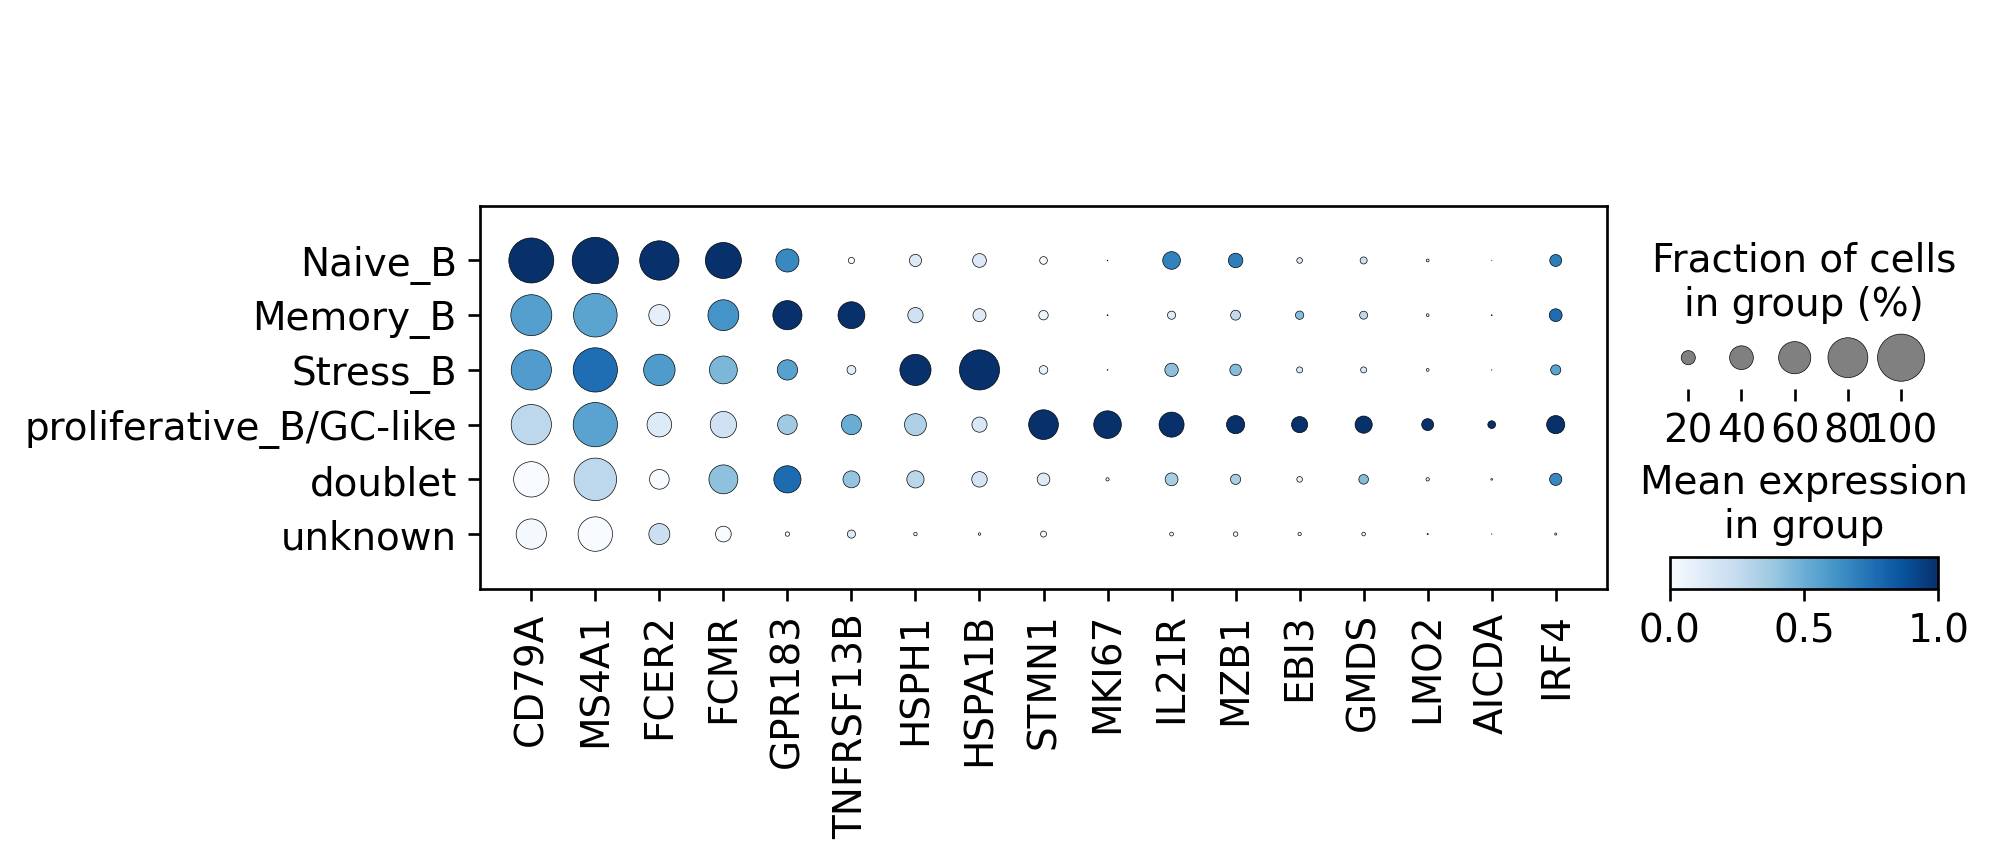

In [75]:
#genes = ['CD79A','MS4A1','TUBA1B','STMN1','MKI67','TOP2A','CD83','BCL2A1','EBI3','REL','IRF4','BCL6','SUGCT','ITGAX','BANK1',
#         'MX1','ISG15','TCL1A','FCER2','IGHG1','IGHG3',
 #        'BAG3','HSPH1','LILRA4','IL3RA','CLEC4C','SCT','PLD4','JCHAIN',
 #        'IL21R','CXCR5','MZB1','TNFRSF13C','CXCR4','IL7R','AICDA','CR2','IGHM','CD27','IGHA1','IGHA2','IRF4','FOXO1',
 #        'ITGAM','CD1C','CLEC10A','IRF8','CD40','CD40LG','CD274','PDCD1LG2','ITGAX','CD38','FCER2','CD22','CXCR5']

categories_order = ['Naive_B','Memory_B','Stress_B','proliferative_B/GC-like','doublet','unknown']
genes = ['CD79A','MS4A1','FCER2','FCMR','GPR183','TNFRSF13B','HSPH1','HSPA1B','STMN1','MKI67',
         'IL21R','MZB1','EBI3','GMDS','LMO2','AICDA','IRF4']
#sc.tl.dendrogram(adata_filtered_harmony_sub, groupby='annotation')
dp = sc.pl.dotplot(adata_filtered_harmony, genes, groupby='annotation', use_raw=True, dendrogram=False, 
                   color_map='Blues',standard_scale='var',categories_order = categories_order)